Interactively figure out MGRS tiles and track numbers

In [1]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [11]:
yaml_file = 'events/cipongkor_landslides_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'cipongkor_landslides_2024',
 'bounds': [107.29793288, -6.9549793, 107.32434909, -6.92756748],
 'event_date': '2024-03-24',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [7, 109],
 'mgrs_tiles': ['48MYT'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange',
 'links': ['https://reliefweb.int/map/indonesia/landslide-impact-analysis-cipongkor-sub-district-bandung-barat-district-jawa-barat-province-indonesia-29-march-2024-imagery-analysis-29032024-published-18042024-v1',
  'https://www.kompas.id/baca/english/2024/03/30/en-puasa-berselimut-duka-korban-longsor-cipongkor-di-bandung-barat',
  'data: https://data.humdata.org/dataset/landslide-impact-analysis-in-cipongkor-sub-district-bandung-barat-district-jawa-barat-prov ']}

# Read Geojson

In [3]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [4]:
# df_event.plot()

In [5]:
df_event.head()

,name,date,source_id,geometry
0,cipongkor_landslides_2024,2024-03-24,UNOSAT via humanitarian data exchange,"MULTIPOLYGON (((107.30703 -6.95475, 107.30703 ..."


In [6]:
df_event.total_bounds

array([107.29793288,  -6.9549793 , 107.32434909,  -6.92756748])

# Create Spatial AOI

In [7]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [8]:
bounds = aoi.bounds
bounds

(107.29793288100007,
 -6.954979295999919,
 107.32434909000006,
 -6.927567477999958)

# Find MGRS tiles and Explore

In [9]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
1,48MYT,32748,"MULTIPOLYGON(((699960 9300040,699960 9190240,8...","MULTIPOLYGON (((106.80764 -6.32935, 106.81137 ..."


In [10]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [18]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['48MYT']

In [19]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

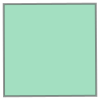

In [20]:
search_geo

# Explore Availability of RTC Data

In [21]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [22]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

237

In [23]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

121

In [24]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [25]:
df_rtc_resp_pre_e.pathNumber.unique()

array([149,  98,  25,  47])

In [27]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
# df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([98, 149])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [91]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((15.78070 -4.74031, 15.07174 -4.58247...",-4.754721,15.405848,2024-02-23T04:36:00Z,OPERA_L2_RTC-S1_T109-233083-IW3_20240223T04355...,DESCENDING,109,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-02-23T04:35:57Z,...,None,IW3,OPERA_L2_RTC-S1_T109-233083-IW3_20240223T04355...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((15.81755 -4.57406, 15.10823 -4.41632...",-4.578297,15.444617,2024-02-23T04:35:57Z,OPERA_L2_RTC-S1_T109-233082-IW3_20240223T04355...,DESCENDING,109,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-02-23T04:35:54Z,...,None,IW3,OPERA_L2_RTC-S1_T109-233082-IW3_20240223T04355...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((16.60826 -4.68841, 15.79805 -4.50917...",-4.682226,16.185680,2024-02-23T04:35:56Z,OPERA_L2_RTC-S1_T109-233082-IW2_20240223T04355...,DESCENDING,109,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-02-23T04:35:53Z,...,None,IW2,OPERA_L2_RTC-S1_T109-233082-IW2_20240223T04355...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((15.85491 -4.40806, 15.14415 -4.25017...",-4.412138,15.481274,2024-02-23T04:35:54Z,OPERA_L2_RTC-S1_T109-233081-IW3_20240223T04355...,DESCENDING,109,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-02-23T04:35:51Z,...,None,IW3,OPERA_L2_RTC-S1_T109-233081-IW3_20240223T04355...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((16.64434 -4.52184, 15.83542 -4.34305...",-4.515654,16.221576,2024-02-23T04:35:53Z,OPERA_L2_RTC-S1_T109-233081-IW2_20240223T04355...,DESCENDING,109,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-02-23T04:35:50Z,...,None,IW2,OPERA_L2_RTC-S1_T109-233081-IW2_20240223T04355...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
